In [1]:

import os
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    matthews_corrcoef
)
import xgboost as xgb
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, inchi
from rdkit.Avalon import pyAvalonTools

warnings.filterwarnings('ignore')

# ============================================================================
# Feature Generation Functions
# ============================================================================

def generate_avalon_features(smiles_list, n_bits=2048):
    """Generate Avalon fingerprints"""
    features = []
    valid_indices = []
    
    for idx, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = pyAvalonTools.GetAvalonFP(mol, nBits=n_bits)
            features.append(np.array(fp))
            valid_indices.append(idx)
    
    return np.array(features), valid_indices

def generate_rdkit2d_features(smiles_list):
    """Generate RDKit 2D descriptors"""
    features = []
    valid_indices = []
    
    descriptor_names = [desc[0] for desc in Descriptors._descList]
    
    for idx, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            desc_values = []
            for desc_name in descriptor_names:
                desc_func = getattr(Descriptors, desc_name)
                try:
                    value = desc_func(mol)
                    desc_values.append(value if not np.isnan(value) else 0)
                except:
                    desc_values.append(0)
            features.append(desc_values)
            valid_indices.append(idx)
    
    return np.array(features), valid_indices

def generate_ecfp6_features(smiles_list, radius=3, n_bits=2048):
    """Generate ECFP6 (Morgan) fingerprints with radius 3"""
    features = []
    valid_indices = []
    
    for idx, smiles in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
            features.append(np.array(fp))
            valid_indices.append(idx)
    
    return np.array(features), valid_indices

def smiles_to_inchikey(smiles):
    """Convert SMILES to InChIKey"""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        return inchi.MolToInchiKey(mol)
    except:
        return None

# ============================================================================
# Data Preparation
# ============================================================================

def prepare_recognizability_data(
    augmented_data_dir='../data/augment_all',
    output_dir='../data/recognizability'
):
    """
    Prepare data for recognizability analysis
    
    Steps:
    1. Load all augmented datasets
    2. Extract SMILES and AUG columns
    3. Compute InChIKey
    4. If compound has both AUG=True and AUG=False, keep only AUG=False
    5. Drop duplicates
    6. Save cleaned datasets
    
    Parameters:
    -----------
    augmented_data_dir : str
        Directory containing augmented datasets
    output_dir : str
        Directory to save cleaned datasets
        
    Returns:
    --------
    dict : Dictionary mapping dataset names to cleaned dataframes
    """
    
    # Create output directory
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Get all augmented dataset files
    dataset_files = sorted(Path(augmented_data_dir).glob('*_augmented.parquet'))
    
    print(f"Found {len(dataset_files)} augmented datasets")
    print("="*80)
    
    cleaned_datasets = {}
    
    for dataset_file in dataset_files:
        # Extract original dataset name
        dataset_name = dataset_file.stem.replace('_augmented', '')
        
        print(f"\nProcessing: {dataset_name}")
        
        # Load augmented dataset
        df = pd.read_parquet(dataset_file)
        
        print(f"  Original size: {len(df)} entries")
        
        # Extract SMILES and AUG columns
        df_clean = df[['SMILES', 'AUG']].copy()
        
        # Remove any NaN SMILES
        df_clean = df_clean.dropna(subset=['SMILES'])
        
        # Compute InChIKey
        print("  Computing InChIKeys...")
        df_clean['InChIKey'] = df_clean['SMILES'].apply(smiles_to_inchikey)
        
        # Remove any failed InChIKey conversions
        df_clean = df_clean.dropna(subset=['InChIKey'])
        
        print(f"  After InChIKey computation: {len(df_clean)} entries")
        
        # For each InChIKey, if both AUG=True and AUG=False exist, keep only AUG=False
        print("  Resolving duplicates (keeping non-augmented when both exist)...")
        
        # Group by InChIKey and check for conflicts
        def resolve_augmentation(group):
            """If both True and False exist, keep False; otherwise keep what exists"""
            if len(group) == 1:
                return group
            # Check if both True and False exist
            has_false = (group['AUG'] == False).any()
            if has_false:
                # Keep only non-augmented (AUG=False)
                return group[group['AUG'] == False].iloc[[0]]
            else:
                # All are augmented, keep first
                return group.iloc[[0]]
        
        df_resolved = df_clean.groupby('InChIKey', group_keys=False).apply(resolve_augmentation)
        
        print(f"  After resolving duplicates: {len(df_resolved)} entries")
        
        # Drop any remaining duplicates (shouldn't be any, but just in case)
        df_resolved = df_resolved.drop_duplicates(subset=['InChIKey'])
        
        print(f"  Final size: {len(df_resolved)} unique compounds")
        
        # Count class distribution
        n_aug = (df_resolved['AUG'] == True).sum()
        n_non_aug = (df_resolved['AUG'] == False).sum()
        
        print(f"  Class distribution:")
        print(f"    Non-augmented (AUG=False): {n_non_aug} ({100*n_non_aug/len(df_resolved):.1f}%)")
        print(f"    Augmented (AUG=True):      {n_aug} ({100*n_aug/len(df_resolved):.1f}%)")
        
        # Add dataset source column
        df_resolved['dataset_source'] = dataset_name
        
        # Save cleaned dataset
        output_file = Path(output_dir) / f'{dataset_name}_recognizability.parquet'
        df_resolved.to_parquet(output_file, index=False)
        
        print(f"  ✓ Saved to: {output_file}")
        
        cleaned_datasets[dataset_name] = df_resolved
    
    print(f"\n{'='*80}")
    print("Data preparation complete!")
    print(f"Cleaned datasets saved in: {output_dir}")
    
    return cleaned_datasets

# ============================================================================
# Recognizability Classification - COMBINED DATASETS
# ============================================================================

def run_recognizability_classification_combined(
    data_dir='../data/recognizability',
    output_dir='../data/recognizability',
    n_folds=5,
    n_replicates=3,
    random_seed=42
):
    """
    Run classification models on ALL datasets combined
    
    Parameters:
    -----------
    data_dir : str
        Directory containing cleaned recognizability datasets
    output_dir : str
        Directory to save prediction results
    n_folds : int
        Number of cross-validation folds
    n_replicates : int
        Number of model replicates
    random_seed : int
        Random seed for reproducibility
    """
    
    # Create output directory
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Get all dataset files
    dataset_files = sorted(Path(data_dir).glob('*_recognizability.parquet'))
    
    print(f"Found {len(dataset_files)} datasets")
    print("="*80)
    
    # Load and combine all datasets
    print("\nLoading and combining all datasets...")
    all_dfs = []
    
    for dataset_file in dataset_files:
        dataset_name = dataset_file.stem.replace('_recognizability', '')
        df = pd.read_parquet(dataset_file)
        
        # Ensure dataset_source column exists
        if 'dataset_source' not in df.columns:
            df['dataset_source'] = dataset_name
        
        all_dfs.append(df)
        print(f"  Loaded {dataset_name}: {len(df)} compounds")
    
    # Combine all datasets
    combined_df = pd.concat(all_dfs, ignore_index=True)
    
    print(f"\n{'='*80}")
    print(f"COMBINED DATASET STATISTICS")
    print(f"{'='*80}")
    print(f"Total compounds: {len(combined_df)}")
    
    # Check for global duplicates across datasets (by InChIKey)
    print(f"\nChecking for duplicates across datasets...")
    n_before = len(combined_df)
    
    # If compound appears in multiple datasets, keep only one (prioritize non-augmented)
    def resolve_global_duplicates(group):
        if len(group) == 1:
            return group
        # Prioritize non-augmented
        has_false = (group['AUG'] == False).any()
        if has_false:
            return group[group['AUG'] == False].iloc[[0]]
        else:
            return group.iloc[[0]]
    
    combined_df = combined_df.groupby('InChIKey', group_keys=False).apply(resolve_global_duplicates)
    combined_df = combined_df.reset_index(drop=True)
    
    n_after = len(combined_df)
    print(f"  Before: {n_before} compounds")
    print(f"  After:  {n_after} compounds")
    print(f"  Removed: {n_before - n_after} duplicates")
    
    # Class distribution
    n_aug = (combined_df['AUG'] == True).sum()
    n_non_aug = (combined_df['AUG'] == False).sum()
    
    print(f"\nClass distribution:")
    print(f"  Non-augmented (AUG=False): {n_non_aug} ({100*n_non_aug/len(combined_df):.1f}%)")
    print(f"  Augmented (AUG=True):      {n_aug} ({100*n_aug/len(combined_df):.1f}%)")
    
    # Check if we have enough samples
    if n_aug < 10 or n_non_aug < 10:
        print(f"\n⚠️  ERROR: Insufficient samples in one class!")
        return
    
    print(f"\n{'='*80}")
    print("TRAINING CLASSIFICATION MODELS ON COMBINED DATASET")
    print(f"{'='*80}")
    
    # Initialize results storage
    results_df = combined_df.copy()
    
    # Convert AUG to binary (0=False, 1=True)
    y = combined_df['AUG'].astype(int).values
    
    # Descriptor types - ONLY AVALON
    descriptor_types = ['avalon']
    
    # Stratified K-Fold for balanced splits
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
    
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(combined_df, y)):
        print(f"\n{'='*80}")
        print(f"FOLD {fold_idx + 1}/{n_folds}")
        print(f"{'='*80}")
        
        train_df = combined_df.iloc[train_idx]
        test_df = combined_df.iloc[test_idx]
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        print(f"Train: {len(train_df)} compounds (Aug={y_train.sum()}, {100*y_train.mean():.1f}%)")
        print(f"Test:  {len(test_df)} compounds (Aug={y_test.sum()}, {100*y_test.mean():.1f}%)")
        
        # For each descriptor type
        for descriptor_type in descriptor_types:
            print(f"\n--- Descriptor: {descriptor_type.upper()} ---")
            
            # Generate features
            print("  Generating features...")
            if descriptor_type == 'avalon':
                X_train, valid_train = generate_avalon_features(train_df['SMILES'].tolist())
                X_test, valid_test = generate_avalon_features(test_df['SMILES'].tolist())
                
            elif descriptor_type == 'rdkit2d':
                X_train, valid_train = generate_rdkit2d_features(train_df['SMILES'].tolist())
                X_test, valid_test = generate_rdkit2d_features(test_df['SMILES'].tolist())
                
            elif descriptor_type == 'ecfp6':
                X_train, valid_train = generate_ecfp6_features(train_df['SMILES'].tolist())
                X_test, valid_test = generate_ecfp6_features(test_df['SMILES'].tolist())
            
            print(f"  Train features: {X_train.shape}")
            print(f"  Test features:  {X_test.shape}")
            
            # Filter valid samples
            y_train_valid = y_train[valid_train]
            y_test_valid = y_test[valid_test]
            test_indices = test_df.index[valid_test]
            
            # For each replicate
            for replicate in range(n_replicates):
                print(f"  Training replicate {replicate + 1}/{n_replicates}...", end=' ')
                
                # Set seed for this replicate
                rep_seed = random_seed + fold_idx * 100 + replicate
                
                # Train XGBoost classifier
                model = xgb.XGBClassifier(
                    n_estimators=100,
                    max_depth=6,
                    learning_rate=0.1,
                    random_state=rep_seed,
                    n_jobs=-1,
                    eval_metric='logloss'
                )
                
                model.fit(X_train, y_train_valid)
                
                # Get probability predictions (probability of being augmented, class 1)
                pred_proba = model.predict_proba(X_test)[:, 1]
                
                # Store predictions (probabilities)
                col_name = f'pred_fold{fold_idx+1}_{descriptor_type}_rep{replicate+1}_proba'
                
                # Initialize column if needed
                if col_name not in results_df.columns:
                    results_df[col_name] = np.nan
                
                # Store predictions at correct indices
                results_df.loc[test_indices, col_name] = pred_proba
                
                # Calculate metrics for this fold/replicate
                pred_binary = (pred_proba >= 0.5).astype(int)
                bal_acc = balanced_accuracy_score(y_test_valid, pred_binary)
                mcc = matthews_corrcoef(y_test_valid, pred_binary)
                
                print(f"BalAcc={bal_acc:.3f}, MCC={mcc:.3f}")
    
    # Calculate aggregate metrics
    print(f"\n{'='*80}")
    print("AGGREGATE PERFORMANCE")
    print(f"{'='*80}")
    
    pred_cols = [c for c in results_df.columns if c.startswith('pred_')]
    
    if pred_cols:
        # Average predictions across all models
        results_df['mean_proba'] = results_df[pred_cols].mean(axis=1)
        results_df['std_proba'] = results_df[pred_cols].std(axis=1)
        
        # Calculate overall metrics
        y_true = results_df['AUG'].astype(int).values
        y_pred_proba = results_df['mean_proba'].values
        y_pred_binary = (y_pred_proba >= 0.5).astype(int)
        
        bal_acc = balanced_accuracy_score(y_true, y_pred_binary)
        mcc = matthews_corrcoef(y_true, y_pred_binary)
        precision = precision_score(y_true, y_pred_binary, zero_division=0)
        recall = recall_score(y_true, y_pred_binary, zero_division=0)
        f1 = f1_score(y_true, y_pred_binary, zero_division=0)
        
        try:
            auc = roc_auc_score(y_true, y_pred_proba)
            ap = average_precision_score(y_true, y_pred_proba)
        except:
            auc = np.nan
            ap = np.nan
        
        print(f"\nOverall Performance (Combined Model):")
        print(f"  Balanced Accuracy: {bal_acc:.4f}")
        print(f"  MCC:               {mcc:.4f}")
        print(f"  Precision:         {precision:.4f}")
        print(f"  Recall:            {recall:.4f}")
        print(f"  F1-Score:          {f1:.4f}")
        print(f"  ROC-AUC:           {auc:.4f}")
        print(f"  Avg Prec:          {ap:.4f}")
        
        # Performance by dataset
        print(f"\nPerformance by Dataset Source:")
        print(f"{'Dataset':<40} {'N':<8} {'BalAcc':<8} {'MCC':<8} {'F1':<8} {'AUC':<8}")
        print("-" * 90)
        
        for dataset_name in results_df['dataset_source'].unique():
            mask = results_df['dataset_source'] == dataset_name
            df_subset = results_df[mask]
            
            y_true_subset = df_subset['AUG'].astype(int).values
            y_pred_proba_subset = df_subset['mean_proba'].values
            y_pred_binary_subset = (y_pred_proba_subset >= 0.5).astype(int)
            
            bal_acc_subset = balanced_accuracy_score(y_true_subset, y_pred_binary_subset)
            mcc_subset = matthews_corrcoef(y_true_subset, y_pred_binary_subset)
            f1_subset = f1_score(y_true_subset, y_pred_binary_subset, zero_division=0)
            
            try:
                auc_subset = roc_auc_score(y_true_subset, y_pred_proba_subset)
            except:
                auc_subset = np.nan
            
            print(f"{dataset_name:<40} {len(df_subset):<8} "
                  f"{bal_acc_subset:<8.3f} {mcc_subset:<8.3f} {f1_subset:<8.3f} {auc_subset:<8.3f}")
    
    # Save results
    output_file = Path(output_dir) / 'combined_recognizability_predictions.parquet'
    results_df.to_parquet(output_file, index=False)
    
    print(f"\n✓ Results saved to: {output_file}")
    print(f"  Total compounds: {len(results_df)}")
    print(f"  Total columns: {len(results_df.columns)}")
    print(f"  Prediction columns: {len(pred_cols)}")
    
    return results_df

# ============================================================================
# Generate Summary Report
# ============================================================================

def generate_recognizability_report_combined(data_dir='../data/recognizability'):
    """
    Generate a summary report of combined recognizability performance
    
    Parameters:
    -----------
    data_dir : str
        Directory containing prediction results
    """
    
    result_file = Path(data_dir) / 'combined_recognizability_predictions.parquet'
    
    if not result_file.exists():
        print("No combined prediction file found")
        return
    
    print("\n" + "="*80)
    print("RECOGNIZABILITY PERFORMANCE SUMMARY (COMBINED MODEL)")
    print("="*80)
    
    df = pd.read_parquet(result_file)
    
    # Check if we have predictions
    if 'mean_proba' not in df.columns:
        print("No predictions found in results file")
        return
    
    # Overall performance
    y_true = df['AUG'].astype(int).values
    y_pred_proba = df['mean_proba'].values
    y_pred_binary = (y_pred_proba >= 0.5).astype(int)
    
    bal_acc = balanced_accuracy_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    
    try:
        auc = roc_auc_score(y_true, y_pred_proba)
        ap = average_precision_score(y_true, y_pred_proba)
    except:
        auc = np.nan
        ap = np.nan
    
    print(f"\nOVERALL PERFORMANCE:")
    print(f"  Total Compounds:    {len(df)}")
    print(f"  Augmented:          {y_true.sum()} ({100*y_true.mean():.1f}%)")
    print(f"  Non-augmented:      {len(df) - y_true.sum()} ({100*(1-y_true.mean()):.1f}%)")
    print(f"\n  Balanced Accuracy:  {bal_acc:.4f}")
    print(f"  MCC:                {mcc:.4f}")
    print(f"  Precision:          {precision:.4f}")
    print(f"  Recall:             {recall:.4f}")
    print(f"  F1-Score:           {f1:.4f}")
    print(f"  ROC-AUC:            {auc:.4f}")
    print(f"  Average Precision:  {ap:.4f}")
    
    # Performance by dataset
    print(f"\n{'='*80}")
    print("PERFORMANCE BY DATASET SOURCE")
    print(f"{'='*80}")
    
    summary_data = []
    
    for dataset_name in sorted(df['dataset_source'].unique()):
        mask = df['dataset_source'] == dataset_name
        df_subset = df[mask]
        
        y_true_subset = df_subset['AUG'].astype(int).values
        y_pred_proba_subset = df_subset['mean_proba'].values
        y_pred_binary_subset = (y_pred_proba_subset >= 0.5).astype(int)
        
        bal_acc_subset = balanced_accuracy_score(y_true_subset, y_pred_binary_subset)
        mcc_subset = matthews_corrcoef(y_true_subset, y_pred_binary_subset)
        precision_subset = precision_score(y_true_subset, y_pred_binary_subset, zero_division=0)
        recall_subset = recall_score(y_true_subset, y_pred_binary_subset, zero_division=0)
        f1_subset = f1_score(y_true_subset, y_pred_binary_subset, zero_division=0)
        
        try:
            auc_subset = roc_auc_score(y_true_subset, y_pred_proba_subset)
            ap_subset = average_precision_score(y_true_subset, y_pred_proba_subset)
        except:
            auc_subset = np.nan
            ap_subset = np.nan
        
        summary_data.append({
            'dataset': dataset_name,
            'n_samples': len(df_subset),
            'n_augmented': y_true_subset.sum(),
            'pct_augmented': 100 * y_true_subset.mean(),
            'balanced_accuracy': bal_acc_subset,
            'mcc': mcc_subset,
            'precision': precision_subset,
            'recall': recall_subset,
            'f1_score': f1_subset,
            'roc_auc': auc_subset,
            'avg_precision': ap_subset
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('roc_auc', ascending=False)
    
    print(f"\n{'Dataset':<40} {'N':<8} {'%Aug':<8} {'BalAcc':<8} {'MCC':<8} {'F1':<8} {'AUC':<8}")
    print("-" * 90)
    
    for _, row in summary_df.iterrows():
        print(f"{row['dataset']:<40} {row['n_samples']:<8.0f} "
              f"{row['pct_augmented']:<8.1f} {row['balanced_accuracy']:<8.3f} "
              f"{row['mcc']:<8.3f} {row['f1_score']:<8.3f} {row['roc_auc']:<8.3f}")
    
    # Save summary
    summary_path = Path(data_dir) / 'recognizability_combined_summary.csv'
    summary_df.to_csv(summary_path, index=False)
    print(f"\n✓ Summary saved to: {summary_path}")
    
    return summary_df


def print_all_performance(data_dir='../data/recognizability'):
    """
    Print comprehensive performance report from saved predictions
    Use this to view all performance metrics after training is complete
    
    Parameters:
    -----------
    data_dir : str
        Directory containing prediction results
    
    Usage:
    ------
    # After training, just call this to see all results:
    from recognizability_analysis import print_all_performance
    print_all_performance('../data/recognizability')
    """
    
    result_file = Path(data_dir) / 'combined_recognizability_predictions.parquet'
    
    if not result_file.exists():
        print(f"❌ No results file found at: {result_file}")
        print("   Run the training pipeline first!")
        return None
    
    print("\n" + "="*80)
    print("COMPLETE RECOGNIZABILITY PERFORMANCE REPORT")
    print("="*80)
    
    # Load results
    df = pd.read_parquet(result_file)
    
    if 'mean_proba' not in df.columns:
        print("❌ No predictions found in results file")
        return None
    
    # ========================================================================
    # 1. OVERALL STATISTICS
    # ========================================================================
    print("\n" + "="*80)
    print("1. DATASET OVERVIEW")
    print("="*80)
    
    print(f"\nTotal unique compounds: {len(df):,}")
    print(f"Number of datasets:     {df['dataset_source'].nunique()}")
    
    n_aug = (df['AUG'] == True).sum()
    n_non_aug = (df['AUG'] == False).sum()
    
    print(f"\nClass Distribution:")
    print(f"  Non-augmented: {n_non_aug:,} ({100*n_non_aug/len(df):.2f}%)")
    print(f"  Augmented:     {n_aug:,} ({100*n_aug/len(df):.2f}%)")
    
    # ========================================================================
    # 2. OVERALL MODEL PERFORMANCE
    # ========================================================================
    print("\n" + "="*80)
    print("2. OVERALL MODEL PERFORMANCE (All Datasets Combined)")
    print("="*80)
    
    y_true = df['AUG'].astype(int).values
    y_pred_proba = df['mean_proba'].values
    y_pred_binary = (y_pred_proba >= 0.5).astype(int)
    
    bal_acc = balanced_accuracy_score(y_true, y_pred_binary)
    mcc = matthews_corrcoef(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    
    try:
        auc = roc_auc_score(y_true, y_pred_proba)
        ap = average_precision_score(y_true, y_pred_proba)
    except:
        auc = np.nan
        ap = np.nan
    
    print(f"\nClassification Metrics:")
    print(f"  Balanced Accuracy:  {bal_acc:.4f}")
    print(f"  MCC:                {mcc:.4f}")
    print(f"  Precision:          {precision:.4f}")
    print(f"  Recall:             {recall:.4f}")
    print(f"  F1-Score:           {f1:.4f}")
    print(f"  ROC-AUC:            {auc:.4f}")
    print(f"  Average Precision:  {ap:.4f}")
    
    # Prediction uncertainty
    print(f"\nPrediction Statistics:")
    print(f"  Mean probability:   {y_pred_proba.mean():.4f}")
    print(f"  Std probability:    {y_pred_proba.std():.4f}")
    print(f"  Mean uncertainty:   {df['std_proba'].mean():.4f}")
    
    # ========================================================================
    # 3. PERFORMANCE BY DESCRIPTOR TYPE
    # ========================================================================
    print("\n" + "="*80)
    print("3. DESCRIPTOR TYPE: AVALON")
    print("="*80)
    
    # Get all avalon columns
    avalon_cols = [c for c in df.columns if '_avalon_' in c and 'pred_' in c]
    
    if avalon_cols:
        # Average predictions for avalon
        avalon_proba = df[avalon_cols].mean(axis=1).values
        avalon_binary = (avalon_proba >= 0.5).astype(int)
        
        bal_acc_avalon = balanced_accuracy_score(y_true, avalon_binary)
        mcc_avalon = matthews_corrcoef(y_true, avalon_binary)
        f1_avalon = f1_score(y_true, avalon_binary, zero_division=0)
        
        try:
            auc_avalon = roc_auc_score(y_true, avalon_proba)
        except:
            auc_avalon = np.nan
        
        print(f"\nAVALON Fingerprints:")
        print(f"  Models:            {len(avalon_cols)}")
        print(f"  Balanced Accuracy: {bal_acc_avalon:.4f}")
        print(f"  MCC:               {mcc_avalon:.4f}")
        print(f"  F1-Score:          {f1_avalon:.4f}")
        print(f"  ROC-AUC:           {auc_avalon:.4f}")
    else:
        print("\nNo Avalon predictions found")
    
    # ========================================================================
    # 4. PERFORMANCE BY DATASET
    # ========================================================================
    print("\n" + "="*80)
    print("4. PERFORMANCE BY DATASET SOURCE")
    print("="*80)
    
    dataset_results = []
    
    for dataset_name in sorted(df['dataset_source'].unique()):
        mask = df['dataset_source'] == dataset_name
        df_subset = df[mask]
        
        y_true_subset = df_subset['AUG'].astype(int).values
        y_pred_proba_subset = df_subset['mean_proba'].values
        y_pred_binary_subset = (y_pred_proba_subset >= 0.5).astype(int)
        
        bal_acc_subset = balanced_accuracy_score(y_true_subset, y_pred_binary_subset)
        mcc_subset = matthews_corrcoef(y_true_subset, y_pred_binary_subset)
        precision_subset = precision_score(y_true_subset, y_pred_binary_subset, zero_division=0)
        recall_subset = recall_score(y_true_subset, y_pred_binary_subset, zero_division=0)
        f1_subset = f1_score(y_true_subset, y_pred_binary_subset, zero_division=0)
        
        try:
            auc_subset = roc_auc_score(y_true_subset, y_pred_proba_subset)
            ap_subset = average_precision_score(y_true_subset, y_pred_proba_subset)
        except:
            auc_subset = np.nan
            ap_subset = np.nan
        
        dataset_results.append({
            'dataset': dataset_name,
            'n_samples': len(df_subset),
            'n_augmented': y_true_subset.sum(),
            'pct_augmented': 100 * y_true_subset.mean(),
            'balanced_accuracy': bal_acc_subset,
            'mcc': mcc_subset,
            'precision': precision_subset,
            'recall': recall_subset,
            'f1_score': f1_subset,
            'roc_auc': auc_subset,
            'avg_precision': ap_subset
        })
    
    results_df = pd.DataFrame(dataset_results)
    
    # Sort by ROC-AUC
    results_df = results_df.sort_values('roc_auc', ascending=False)
    
    print(f"\n{'Dataset':<40} {'N':>7} {'%Aug':>6} {'BalAcc':>7} {'MCC':>7} {'Prec':>6} {'Rec':>6} {'F1':>6} {'AUC':>6}")
    print("-" * 105)
    
    for _, row in results_df.iterrows():
        print(f"{row['dataset']:<40} {row['n_samples']:>7.0f} "
              f"{row['pct_augmented']:>6.1f} {row['balanced_accuracy']:>7.3f} "
              f"{row['mcc']:>7.3f} {row['precision']:>6.3f} {row['recall']:>6.3f} "
              f"{row['f1_score']:>6.3f} {row['roc_auc']:>6.3f}")
    
    # ========================================================================
    # 5. CROSS-VALIDATION STATISTICS
    # ========================================================================
    print("\n" + "="*80)
    print("5. CROSS-VALIDATION CONSISTENCY")
    print("="*80)
    
    pred_cols = [c for c in df.columns if c.startswith('pred_fold')]
    n_folds = len(set([c.split('_')[0] for c in pred_cols if 'fold' in c]))
    n_replicates = len([c for c in pred_cols if 'fold1' in c and 'avalon' in c])
    
    print(f"\nCross-validation setup:")
    print(f"  Number of folds:      {n_folds}")
    print(f"  Descriptor type:      Avalon")
    print(f"  Replicates per fold:  {n_replicates}")
    print(f"  Total models:         {len(pred_cols)}")
    
    print(f"\nPrediction consistency:")
    print(f"  Mean std dev:         {df['std_proba'].mean():.4f}")
    print(f"  Max std dev:          {df['std_proba'].max():.4f}")
    print(f"  Min std dev:          {df['std_proba'].min():.4f}")
    
    # ========================================================================
    # 6. SUMMARY STATISTICS
    # ========================================================================
    print("\n" + "="*80)
    print("6. SUMMARY STATISTICS")
    print("="*80)
    
    print(f"\nPer-Dataset Performance (mean ± std):")
    print(f"  Balanced Accuracy: {results_df['balanced_accuracy'].mean():.4f} ± {results_df['balanced_accuracy'].std():.4f}")
    print(f"  MCC:               {results_df['mcc'].mean():.4f} ± {results_df['mcc'].std():.4f}")
    print(f"  Precision:         {results_df['precision'].mean():.4f} ± {results_df['precision'].std():.4f}")
    print(f"  Recall:            {results_df['recall'].mean():.4f} ± {results_df['recall'].std():.4f}")
    print(f"  F1-Score:          {results_df['f1_score'].mean():.4f} ± {results_df['f1_score'].std():.4f}")
    print(f"  ROC-AUC:           {results_df['roc_auc'].mean():.4f} ± {results_df['roc_auc'].std():.4f}")
    
    print(f"\nBest performing dataset:  {results_df.iloc[0]['dataset']} (AUC={results_df.iloc[0]['roc_auc']:.4f}, MCC={results_df.iloc[0]['mcc']:.4f})")
    print(f"Worst performing dataset: {results_df.iloc[-1]['dataset']} (AUC={results_df.iloc[-1]['roc_auc']:.4f}, MCC={results_df.iloc[-1]['mcc']:.4f})")
    
    # ========================================================================
    # 7. FILES GENERATED
    # ========================================================================

    
    summary_file = Path(data_dir) / 'recognizability_combined_summary.csv'
    
    print(f"\nResults saved to:")
    print(f"  Predictions: {result_file}")
    if summary_file.exists():
        print(f"  Summary CSV: {summary_file}")
    
    return results_df


# ============================================================================
# Main Execution
# ============================================================================

if __name__ == "__main__":
    
    # Step 1: Prepare data
    print("\nStep 1: Preparing data...")
    cleaned_datasets = prepare_recognizability_data(
        augmented_data_dir='../data/augment_all',
        output_dir='../data/recognizability'
    )
    
    # Step 2: Run classification on COMBINED dataset
    print("\nStep 2: Running classification models on combined dataset...")
    run_recognizability_classification_combined(
        data_dir='../data/recognizability',
        output_dir='../data/recognizability',
        n_folds=5,
        n_replicates=3,
        random_seed=42
    )
    
    # Step 3: Generate report
    print("\nStep 3: Generating summary report...")
    generate_recognizability_report_combined(
        data_dir='../data/recognizability'
    )
    



Step 1: Preparing data...
Found 17 augmented datasets

Processing: Cell Proliferation (IC50)
  Original size: 431 entries
  Computing InChIKeys...
  After InChIKey computation: 431 entries
  Resolving duplicates (keeping non-augmented when both exist)...
  After resolving duplicates: 431 entries
  Final size: 431 unique compounds
  Class distribution:
    Non-augmented (AUG=False): 243 (56.4%)
    Augmented (AUG=True):      188 (43.6%)
  ✓ Saved to: ../data/recognizability/Cell Proliferation (IC50)_recognizability.parquet

Processing: Clearance Microsomal (Mouse)
  Original size: 4683 entries
  Computing InChIKeys...
  After InChIKey computation: 4683 entries
  Resolving duplicates (keeping non-augmented when both exist)...
  After resolving duplicates: 4683 entries
  Final size: 4683 unique compounds
  Class distribution:
    Non-augmented (AUG=False): 3797 (81.1%)
    Augmented (AUG=True):      886 (18.9%)
  ✓ Saved to: ../data/recognizability/Clearance Microsomal (Mouse)_recognizab

In [2]:
df_res = pd.read_csv('../data/recognizability/recognizability_combined_summary.csv')

(array([3., 0., 2., 2., 3., 0., 3., 0., 0., 2.]),
 array([0.49761779, 0.54785601, 0.59809423, 0.64833245, 0.69857067,
        0.74880889, 0.79904711, 0.84928534, 0.89952356, 0.94976178,
        1.        ]),
 <BarContainer object of 10 artists>)

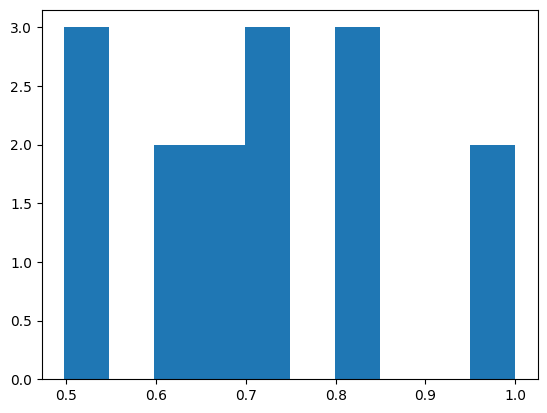

In [4]:
import matplotlib.pyplot as plt
plt.hist(df_res['balanced_accuracy'].tolist(), bins = 10)

In [ ]:
1